# `009` Overfitting

Requirements: 008 Batch normalization

Since batch normalization enabled us to train much deeper networks, a new problem has arisen: **overfitting**. Overfitting occurs when the model learns the training data too well, and it starts to learn the noise in the data. This results in a model that performs well on the training data but poorly on the validation data.

I like to explain overfitting with the history of the "superstitious pigeons". In the 1940s, B.F. Skinner, a psychologist, conducted an experiment with pigeons. He placed them in a box and gave them food at regular intervals. The pigeons started to associate the food with the actions they were doing at the time. For example, if a pigeon was turning in circles when the food arrived, it would start to believe that turning in circles caused the food to appear. This is similar to overfitting. The pigeons were learning the noise in the data (the food appearing at regular intervals) and associating it with their actions. Eventually, all pigeons were doing strange actions that they believed would cause the food to appear.

There are a few properties of our datasets that can make a model overfit:
* Too few training examples.
* Large input spaces that can lead to circumstancial correlations that are not generalizable.
* Irrelevant features in the input data or features that are just combinations of other.
* Unpredictable noise in the output data.

Let's see that in action by creating a dataset that poses these problems.

In [1]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
import torch

# let's use the GPU if we can
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train.shape=torch.Size([150, 50]), x_test.shape=torch.Size([150, 50])


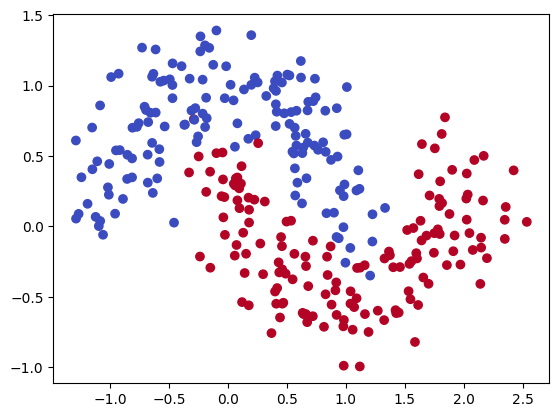

In [2]:
# generate some data
x, y = make_moons(n_samples=300, noise=0.2)
x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=y.cpu(), cmap='coolwarm');

# add redundant features
x = torch.cat([
	x,
	2 * x[:, 0].reshape(-1, 1),
	2 * x[:, 1].reshape(-1, 1),
	torch.atan2(x[:, 1], x[:, 0]).reshape(-1, 1),
], dim=1)

# add noisy features
x = torch.cat([
	x,
	torch.randn(x.size(0), 45).to(device),
], dim=1)


# split the data half-half
cut = x.size(0) // 2
x_train, x_test = x[:cut], x[cut:]
y_train, y_test = y[:cut], y[cut:]

print(f'{x_train.shape=}, {x_test.shape=}')

There are also a few model properties that can contribute to overfitting:
* Large models that can memorize the training data.
* Many training epochs that can lead to the model learning the noise in the data.

Let's create a model that is prone to overfitting.

In [3]:
def get_model(hidden_size=300, hidden_layers=4):
	torch.manual_seed(1234)
	res = [torch.nn.Linear(50, hidden_size, bias=False), torch.nn.BatchNorm1d(hidden_size), torch.nn.ReLU()]
	for _ in range(hidden_layers):
		res.extend([torch.nn.Linear(hidden_size, hidden_size, bias=False), torch.nn.BatchNorm1d(hidden_size), torch.nn.ReLU()])
	res.extend([torch.nn.Linear(hidden_size, 1), torch.nn.Flatten(0, 1)])
	return torch.nn.Sequential(*res).to(device)

model = get_model()
print(f'Model has {sum(p.numel() for p in model.parameters())} parameters')

Model has 378301 parameters


Now let's train the model and keep track of the training and validation losses.

Final MSE loss on test set is 0.152084


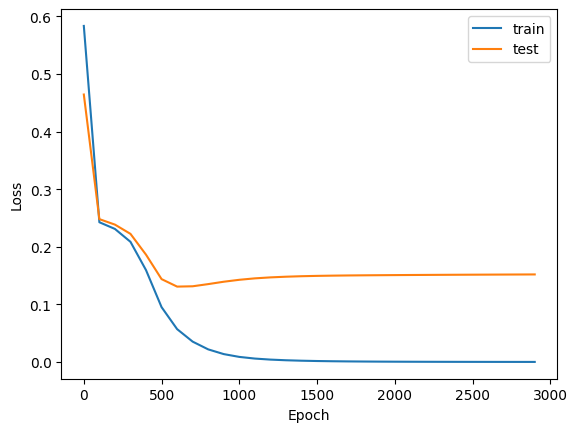

In [4]:
def mse_loss(model, x, y):
	y_pred = model(x)
	return ((y_pred - y)**2).mean()

def train(model, loss_fn, learning_rate=1e-2, epochs=3000, log_each=100):
	optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
	train_losses, test_losses = [], []
	for epoch in range(epochs):
		loss = loss_fn(model, x_train, y_train)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		if epoch % log_each == 0:
			model.eval()
			train_losses.append(loss.item())
			test_losses.append(loss_fn(model, x_test, y_test).item())
	iters = range(0, epochs, log_each)
	plt.plot(iters, train_losses, label='train')
	plt.plot(iters, test_losses, label='test')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()
	print(f'Final MSE loss on test set is {mse_loss(model, x_test, y_test).item():.6f}')

train(model, mse_loss)

Here, the overfit becomes pretty evident, as the training loss keeps decreasing while the validation loss starts to increase.

In mathematics, **regularization** is the process of simplifying the logic of a model to make it simpler. In neural networks, the four most common regularization techniques are:
* Early stopping: stop training when the validation loss starts to increase.
* L1 regularization: add a term to the loss function that penalizes large weights, using the absolute value of the weights.
* L2 regularization: same as L1, but using the square of the weights.
* Dropout: randomly set some neurons to zero during training.

Looking at our loss graph, we can see that the model starts to overfit around epoch 250. However, at that moment the training loss is still rapidly decreasing, so early stopping would not be a good choice. Let test both regularization techniques and see how they perform.

Final MSE loss on test set is 0.148502
Final MSE loss on test set is 0.149188


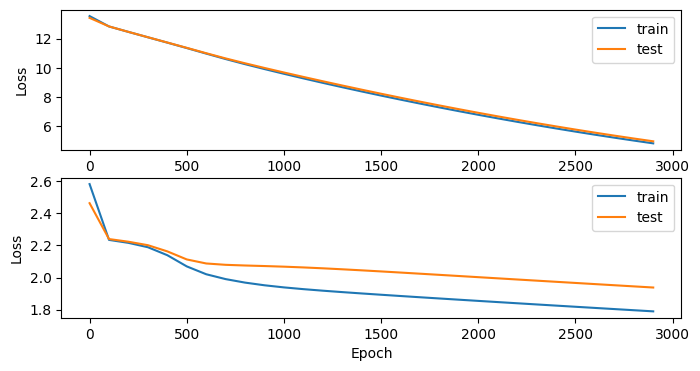

In [5]:
def mse_with_l1_regularization(model, x, y, l1_weight=1e-3):
	loss = mse_loss(model, x, y)
	for p in model.parameters():
		loss += l1_weight * p.abs().sum()
	return loss

def mse_with_l2_regularization(model, x, y, l2_weight=1e-3):
	loss = mse_loss(model, x, y)
	for p in model.parameters():
		loss += l2_weight * (p**2).sum()
	return loss

plt.figure(figsize=(8, 4))
model_l1 = get_model()
plt.subplot(211)
train(model_l1, mse_with_l1_regularization)
model_l2 = get_model()
plt.subplot(212)
train(model_l2, mse_with_l2_regularization)

It might look like L1 and L2 regularization are similar and interchangeable, but they have different effects on the model, as can be seen in the loss charts above.

* In L1 regularization, we are substracting the absolute value of the weights from the loss function. If we thing of the derivative of the loss function, since the derivative of a linear function is a constant, we are always reducing the weights by a constant amount. This can lead to sparse models, where many weights are zero. This can be useful when we want to reduce the model size as much as possible.
* In L2 regularization, we are substracting the square of the weights from the loss function. The derivative of the square function is linear, so we are reducing the weights by an amount proportional to the weight itself. This can lead to smaller weights, but not to zero weights. The purpose of doing this is preventing some weights from becoming too large and dominating the output.

There are also ways to combine L1 and L2 regularization known as Elastic Net regularization, but they are not very common in practice. One downside of using regularization is that it introduces a new hyperparameter that needs to be tuned: the **regularization strength**. In the example above it was hardcoded as $10^{-4}$, but in practice it should be tuned to ensure the best performance.

There is one more regularization technique that is very popular in practice: **Dropout**. Dropout is a technique where we randomly set some neurons to zero during training. This can be seen as training many different models and averaging their outputs. This can be very useful to prevent overfitting, as it forces the model to learn redundant representations of the data.

Final MSE loss on test set is 0.149807


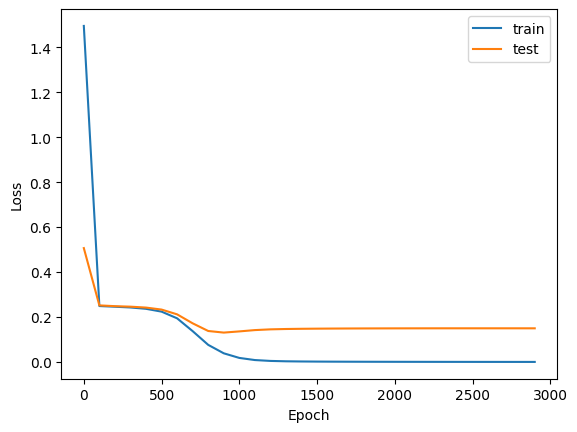

In [6]:
def get_model_with_dropout(hidden_size=500, hidden_layers=5, dropout=0.5):
	torch.manual_seed(1234)
	res = [torch.nn.Linear(50, hidden_size, bias=False), torch.nn.BatchNorm1d(hidden_size), torch.nn.ReLU(), torch.nn.Dropout(dropout)]
	for _ in range(hidden_layers):
		res.extend([torch.nn.Linear(hidden_size, hidden_size, bias=False), torch.nn.BatchNorm1d(hidden_size), torch.nn.ReLU(), torch.nn.Dropout(dropout)])
	res.extend([torch.nn.Linear(hidden_size, 1), torch.nn.Flatten(0, 1)])
	return torch.nn.Sequential(*res).to(device)

model_dropout = get_model_with_dropout()
train(model_dropout, mse_loss)

In our example, dropout is not very useful, as the input features are very simple and specific. In practice, dropout is very useful when the input space is very large and complex, as in language models or image recognition.